# **Entrega 2**

In [2]:

#Import libraries
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt

#Load the data
u_train=np.load('/content/u_train.npy')
y_train=np.load('/content/output_train.npy')
u_test=np.load('/content/u_test.npy')
print(u_train.shape)
print(y_train.shape)
print(u_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2040,)
(2040,)
(510,)


**Função que define phi, ainda com n,k,d,m por definir**

In [3]:
#Phi Function, receives y,u,k,n,m,d in order to construct a line of the matrix X
def construct_phi(y, u, k, n, m, d):
    if k <= max(n, d + m):
        return None

    phi_y = y[k-1 : k-n-1 : -1]

    phi_u = u[k-d : k-d-m-1 : -1]

    #Combine into a vector
    phi = np.concatenate((phi_y, phi_u))

    return phi

**Melhores parâmetros de n,m,d para criar X_train**

In [9]:
#Load libraries
from sklearn.linear_model import RidgeCV
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Define variables
lowest_error = float('inf')
lowest_mse = float('inf')
best_n = None
best_m = None
best_d = None

# Define function to calculate SSE (Sum of Squared Errors)
def calculate_sse(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

#Define function to calculate MSE (Mean of Squared Errors)
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Iterate over n, m, d to find the best model
for n in range(48, 50):  # n from 1 to 50
    for m in range(47, 50):  # m from 0 to 50
        for d in range(0, 9):  # d from 0 to 9

            X_train = []
            Y_train = []
            T_train = len(y_train)

            for k in range(max(n, m + d), T_train):
                # Construct the regressor vector phi(k) for the current time step
                phi = construct_phi(y_train, u_train, k, n, m, d)

                if phi is None or phi.size == 0:
                    continue  # Skip if insufficient data points

                X_train.append(phi)
                Y_train.append(y_train[k])

            # Convert to NumPy arrays
            X_train = np.array(X_train)
            Y_train = np.array(Y_train)

            if X_train.size == 0 or Y_train.size == 0:
                continue  # Skip if no valid rows were found

            # Use LinearRegression to fit the model
            model = LinearRegression()
            model.fit(X_train, Y_train)

            # Predict training outputs using the model
            y_train_pred = model.predict(X_train)

            # Calculate the SSE and MSE for this model
            error = calculate_sse(Y_train, y_train_pred)
            mse = calculate_mse(Y_train, y_train_pred)

            # Check if this is the best model and save the corresponding parameters
            if error < lowest_error:
                lowest_error = error
                lowest_mse = mse
                best_n = n
                best_m = m
                best_d = d
                bestx=X_train
                besty=Y_train
                best_y_predict=y_train_pred

print(f"Best parameters: n = {best_n}, m = {best_m}, d = {best_d}")
print(f"Lowest error (SSE): {lowest_error}")
print("Mean Squared Error (MSE):", {lowest_mse})

Best parameters: n = 49, m = 49, d = 6
Lowest error (SSE): 18.973291043112834
Mean Squared Error (MSE): {0.00956315072737542}


**Ridge CV**

0.999773441437584
0.009574174847736351
18.99516289790892
The best alpha chosen by RidgeCV is: 1.0


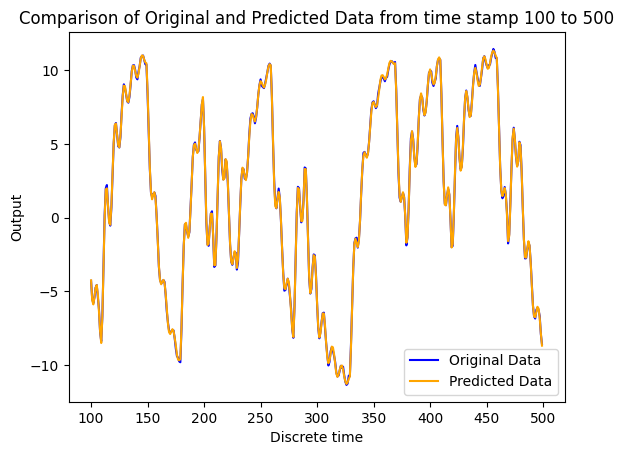

In [10]:
#RidgeCV model (previous submission)

from sklearn.linear_model import RidgeCV

#Create model
clf_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1,10,100],cv=20)
clf_cv.fit(bestx, besty)

#Apply the model to the bestx (X_train from previous function) and get y_predict
y_predict_ridgeCV=clf_cv.predict(bestx)
score_clf_cv=clf_cv.score(bestx, besty)
print(score_clf_cv)

#Compare y_predict with besty (Y_train from previous function)
mse=np.mean((besty - y_predict_ridgeCV) ** 2)
print(mse)
sse_ridge=np.sum((besty-y_predict_ridgeCV)**2)
print(sse_ridge)
print(f"The best alpha chosen by RidgeCV is: {clf_cv.alpha_}")

# Obtained the model coefficients
theta_ridge = clf_cv.coef_
intercept_ridge = clf_cv.intercept_
#print(f"Estimated coefficients (theta) with Ridge: {theta_ridge}")

# Plot the comparison between the original data besty (Y_train) and predicted data (y_predict_ridgeCV)
plt.plot(range(100, 500), besty[100:500], color='blue', label='Original Data')
plt.plot(range(100, 500), y_predict_ridgeCV[100:500], color='orange', label='Predicted Data')

# Add labels and title
plt.xlabel('Discrete time')
plt.ylabel('Output')
plt.title('Comparison of Original and Predicted Data from time stamp 100 to 500')

plt.legend()

# Show the plot
plt.show()

**Cross Validation**

In [11]:
#Load libraries
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize Ridge model (without cross-validation)
ridge_model = Ridge(alpha=1) #Alpha chosen in the previous function

# Initialize lists to store cross-validation results for Ridge
ridge_cv_mse_scores = []
ridge_cv_sse_scores = []

#Apply time sensitive cross validation
tscv = TimeSeriesSplit(n_splits=5)

# TimeSeriesSplit for Ridge cross-validation
for train_index, test_index in tscv.split(bestx):
    X_train_cv, X_test_cv = bestx[train_index], bestx[test_index]
    y_train_cv, y_test_cv = besty[train_index], besty[test_index]

    # Fit Ridge model on training fold
    ridge_model.fit(X_train_cv, y_train_cv)

    # Predict on test fold
    y_pred_ridge_cv = ridge_model.predict(X_test_cv)

    # Calculate MSE and SSE for this fold
    mse_ridge_cv = mean_squared_error(y_test_cv, y_pred_ridge_cv)
    sse_ridge_cv = np.sum((y_test_cv - y_pred_ridge_cv) ** 2)

    # Append the results
    ridge_cv_mse_scores.append(mse_ridge_cv)
    ridge_cv_sse_scores.append(sse_ridge_cv)

# Calculate and print the average cross-validated MSE and SSE for Ridge
avg_mse_ridge_cv = np.mean(ridge_cv_mse_scores)
avg_sse_ridge_cv = np.mean(ridge_cv_sse_scores)

print(f"Average Cross-Validated MSE (Ridge): {avg_mse_ridge_cv}")
print(f"Average Cross-Validated SSE (Ridge): {avg_sse_ridge_cv}")
print(ridge_cv_mse_scores)


Average Cross-Validated MSE (Ridge): 0.011233325385320538
Average Cross-Validated SSE (Ridge): 3.7069973771557785
[0.011219224296455523, 0.01122290938167577, 0.011263217957104157, 0.011281134076058623, 0.011180141215308626]


 **Submission y_predict_last_400**

In [17]:
import numpy as np

def arx_model_predict(u_test, y_train, model, num_lags_y, num_lags_u, delay):

    test_length = len(u_test)  # Length of the test set
    y_pred_test = []  # To store predictions for each step

    # Initialize with the last 'num_lags_y' values from y_train
    y_previous = list(y_train[-num_lags_y:])

    # Loop through each step in the test set
    for step in range(test_length):

        # Collect past 'y' values
        lagged_y = [-y_previous[j] for j in range(num_lags_y)]

        # Collect past 'u' values with delay, if not enough, use 0
        lagged_u = [u_test[step - delay - j] if step - delay - j >= 0 else 0 for j in range(num_lags_u)]

        # Combine lagged y and u into the regressor
        regressor = np.hstack((lagged_y, lagged_u))

        # Include intercept (bias term)
        regressor_with_intercept = np.hstack([1, regressor])

        # Ensure the feature vector matches the model's expectations
        if len(regressor_with_intercept) != len(model.coef_):
            raise ValueError(f"Feature count mismatch: Expected {len(model.coef_)} features, but got {len(regressor_with_intercept)}")

        # Predict the next y value using the trained model
        y_next = model.predict(regressor_with_intercept.reshape(1, -1))[0]

        # Store the prediction and update 'y_previous' for the next step
        y_pred_test.append(y_next)
        y_previous = [y_next] + y_previous[:-1]  # Maintain only the last num_lags_y values

    return np.array(y_pred_test)

# Use the updated function to predict y_test
y_pred_test = arx_model_predict(u_test, y_train, clf_cv, best_n, best_m, best_d)

# Extract the last 400 values from the prediction
y_pred_last_400 = y_pred_test[110:510]

# Save the array in .npy format for submission
np.save('y_pred_last_400.npy', y_pred_last_400)

# Also save the results in CSV format
np.savetxt("y_pred_last_400.csv", y_pred_last_400, delimiter=",")
print("Predicted values saved to 'y_pred_last_400.csv'")

Predicted values saved to 'y_pred_last_400.csv'


**Lasso CV**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.772e+01, tolerance: 8.678e+00
  model = cd_fast.enet_coordinate_descent(


0.9996369648725483
31.502566255261605
0.015680719888134197


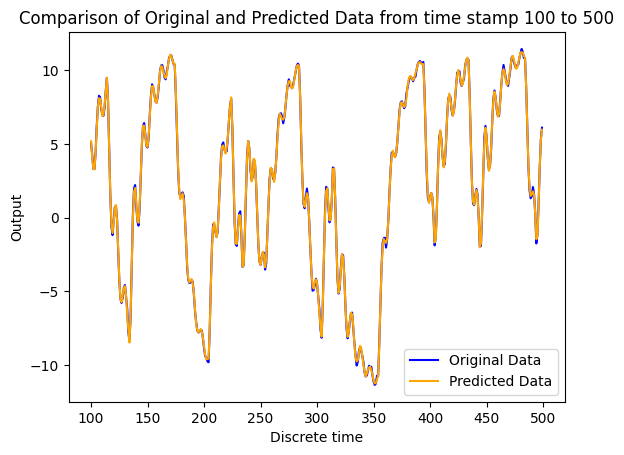

In [ ]:
#LassoCV model (previous submission)
from sklearn.linear_model import LassoCV

#Create and fit the model
lasso_cv = LassoCV(cv=5, random_state=42, alphas=None)
lasso_cv.fit(bestx, besty)

#Apply the model to the bestx (X_train from previous function) and get y_predict
y_predict_lassoCV = lasso_cv.predict(bestx)
train_score_lsCV=lasso_cv.score(bestx, besty)
print(train_score_lsCV)

#Compare y_predict with besty (Y_train from previous function)
sse_lassoCV=np.sum((besty-y_predict_lassoCV)**2)
print(sse_lassoCV)

mse=np.mean((besty - y_predict_lassoCV) ** 2)
print(mse)

# Plot the comparison between the original data besty (Y_train) and predicted data (y_predict_lassoCV)
plt.plot(range(100, 500), besty[100:500], color='blue', label='Original Data')
plt.plot(range(100, 500), y_predict_lassoCV[100:500], color='orange', label='Predicted Data')

# Add labels and title
plt.xlabel('Discrete time')
plt.ylabel('Output')
plt.title('Comparison of Original and Predicted Data from time stamp 100 to 500')

# Add legend
plt.legend()

# Show the plot
plt.show()

**Regressão Linear**

0.9997737023069435
0.00956315072737542
SSE: 18.973291043112834


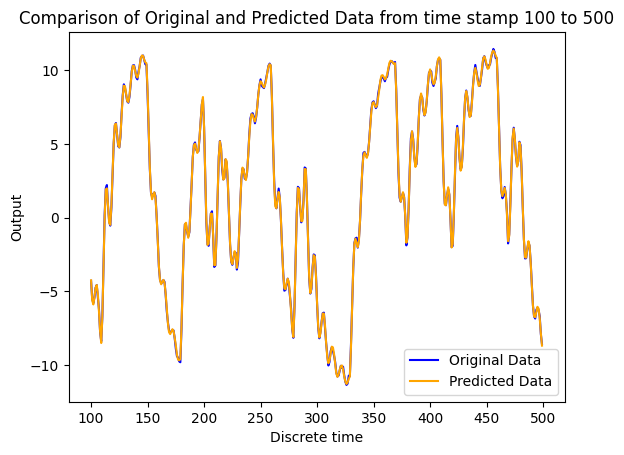

In [ ]:
#Linear Regression model (previous submission)

#Create and fit the model
reg = LinearRegression().fit(bestx, besty)
reg.score(bestx, besty)
print(reg.score(bestx, besty))
reg.coef_
reg.intercept_

#Apply the model to the bestx (X_train from previous function) and get y_predict
y_predict=reg.predict(bestx)

#Compare y_predict with besty (Y_train from previous function)
sse_reg=np.sum((besty-y_predict)**2)
print("SSE:", sse_reg)
mse=np.mean((besty - y_predict) ** 2)
print(mse)

# Plot the comparison between the original data (Y_train) and predicted data (y_predict)
plt.plot(range(100, 500), besty[100:500], color='blue', label='Original Data')
plt.plot(range(100, 500), y_predict[100:500], color='orange', label='Predicted Data')

# Add labels and title
plt.xlabel('Discrete time')
plt.ylabel('Output')
plt.title('Comparison of Original and Predicted Data from time stamp 100 to 500')

# Add legend
plt.legend()

# Show the plot
plt.show()